# Tuberculosis Detection Using CNN From Chest X-rays
---

## Table of Contents
- [ 1 - Import Packages <img align="Right" src="./data/dataset/Normal/Normal-1.png" width = 25% ><img align="Right" src="./data/dataset/Tuberculosis/Tuberculosis-1.png" width = 25% >](#1---import-packages)
- [ 2 - Data Preparations](#2---data-preparations)
  - [ 2.1 Data Augmentation](#21---data-augmentation)
  - [ 2.2 Train and Test Data Split](#22---train-and-test-data-split)
- [ 3 - Building a CNN Model](#3---building-a-cnn-model)
  - [ 3.1 Model](#31---model)
  - [ 3.2 Compiling and Training](#32---compiling-and-training)
- [ 4 - Evaluation](#4---evaluation)
  - [ 4.1 - Loss and Accuracy](#41---loss-and-accuracy)
  - [ 4.2 - Confusion Matrix](#42---confusion-matrix)
  - [ 4.3 - Evaluating On Test Set](#43---evaluating-on-test-set)
- [ 5 - References](#5---references)

---

<a name="1"></a>
## 1 - Import Packages

We'll make use of the following packages:
- `os` is used to access, read and change directories and folders.
- `numpy` is a package for scientific computing in python.
- `matplotlib` will be used for data visualization.
- `cv2` is used for image processing.
- We will use several modules from the `tensorflow.keras` framework for building deep learning models.
- `utils` is a module that contains functions for this project.
- `sklearn.metrics` is used for con
Run the cell below to import all the necessary packages.

In [13]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import random
import utils
from tqdm import tqdm
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay , f1_score

<a name="2"></a>
## 2 - Data Preparations

We'll import the required data from `tuberculosis` and `normal` sets using the `load_data` function from `utils.py`.
Run the cell below to load_data. 

In [14]:
tb_data = "./data/dataset/Tuberculosis"
no_tb_data = "./data/dataset/normal"

X_yes = utils.load_data(tb_data)
X_no = utils.load_data(no_tb_data)

100%|██████████| 3500/3500 [00:22<00:00, 152.31it/s]


<a name="2.1"></a>
### 2.1 - Data Augmentation

Since the number of normal examples are 3500 as compared to 700 TB examples, in order to prevent bias to normal examples we'll use `ImageDataGenerator` from `keras.preprocessing.image` to generate TB examples with slight rotation and shifts. These are the augmented images.

In [15]:
datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2,horizontal_flip=True, fill_mode='nearest')
aug_images = []

for img in tqdm(X_yes):
    for batch in datagen.flow(np.expand_dims(img, 0), batch_size=1):
        aug_images.append(batch[0])
        if len(aug_images) % 5 == 0:
            break

TB_yes = []
for image in tqdm(aug_images):
    TB_yes.append([image, 1])
    
TB_no = []
for image in tqdm(X_no):
    TB_no.append([image, 0])
    
data = TB_yes + TB_no
random.shuffle(data)

100%|██████████| 3500/3500 [00:00<00:00, 864601.21it/s]


<a name="2.2"></a>
### 2.2 - Train and Test Data Split

In [16]:
X = []
Y = []

for i,j in data :
    X.append(i)
    Y.append(j)
X = np.array(X)
Y = np.array(Y)

X_train = X[:5500]
X_test = X[5500:]

Y_train = Y[:5500]
Y_test = Y[5500:]

<a name="3"></a>
## 3 - Building a CNN Model

- To make a CNN model, we'll make use of `tensorflow.keras` libraries and make a `Sequential` model with  convolutional layer using `Conv2D`.
- We'll also use `flatten` to convert `Conv2D` matrix to a 1D matrix so that it can be fed to `Dense` layer.
- `MaxPooling2D` is used to downsize the images to half in both horizontal and vertical direction by changing the value correspoding to a 2*2 area by its max value, thus allowing to run network faster.
- Since we used `ImageDataGenerator` to increase sampling size of TB examples,it can risk overfitting. To prevent this we can use `Dropout` to randomly shutdown some of neurons and thus prevent overfitting data.

<a name="3.1"></a>
### 3.1 - Model

In [17]:
model = Sequential()

model.add(Input(shape=(224, 224, 3)))
model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(1, activation="sigmoid"))


<a name="3.2"></a>
### 3.2 - Compiling and Training

We'll use `adam` optimizer and `binarycrossentropy` loss function. 

In [18]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

history = model.fit(X_train, Y_train, validation_split= .2, epochs = 5)

Epoch 1/5
138/138 ━━━━━━━━━━━━━━━━━━━━ 62s 425ms/step - accuracy: 0.7616 - loss: 31.5547 - val_accuracy: 0.8291 - val_loss: 0.2943
Epoch 2/5
138/138 ━━━━━━━━━━━━━━━━━━━━ 52s 380ms/step - accuracy: 0.8675 - loss: 0.3881 - val_accuracy: 0.9573 - val_loss: 0.1736
Epoch 3/5
138/138 ━━━━━━━━━━━━━━━━━━━━ 54s 393ms/step - accuracy: 0.9368 - loss: 0.2264 - val_accuracy: 0.9418 - val_loss: 0.1704
Epoch 4/5
138/138 ━━━━━━━━━━━━━━━━━━━━ 53s 386ms/step - accuracy: 0.9281 - loss: 0.4245 - val_accuracy: 0.9436 - val_loss: 0.2245
Epoch 5/5
138/138 ━━━━━━━━━━━━━━━━━━━━ 53s 385ms/step - accuracy: 0.9233 - loss: 0.2794 - val_accuracy: 0.9509 - val_loss: 0.1711


<a name="4"></a>
## 4 - Evaluation

<a name="4.1"></a>
### 4.1 - Loss and Accuracy

From `utils` using the functions `plt_accuracy` and `plt_loss` to visualize the accuracy and loss w.r.t. epochs.

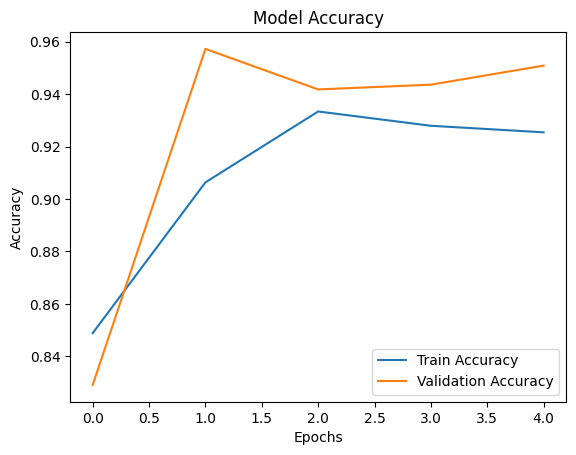

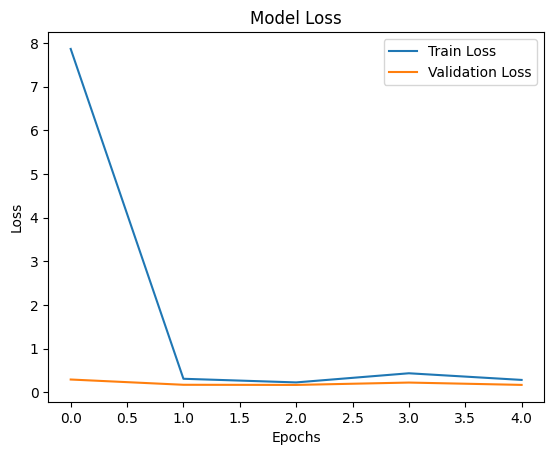

In [19]:
utils.plt_accuracy(history)
utils.plt_loss(history)

<a name="4.2"></a>
### 4.2 - Confusion Matrix

Using `confusion_matrix` and `ConfusionMatrixDisplay` we'll create a confusion matrix so that visualization of test data is clear.

47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step


<Figure size 1200x1000 with 0 Axes>

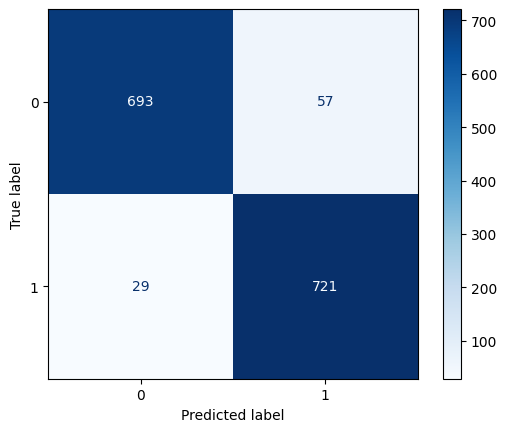

In [20]:
Y_pred = (model.predict(X_test)>=0.5).astype(int)
utils.conf_mat(Y_test,Y_pred)

<a name="4.3"></a>
### 4.3 - Evaluating on Test Set

We'll measure the `accuracy` as well as `f1_score` on the test set. 

In [21]:
loss,accuracy = model.evaluate(X_test, Y_test)
f1 = f1_score(Y_test, Y_pred)
print("The accuracy of the CNN is: ",accuracy)
print("The F1_score for the CNN is: ",f1)

47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.9394 - loss: 0.1592
The accuracy of the CNN is:  0.9426666498184204
The F1_score for the CNN is:  0.943717277486911


<a name="5"></a>
## 5 - References

- [1] S. Jaeger, S. Candemir, S. Antani, Y.-X. J. Wáng, P.-X. Lu, and G. Thoma, "Two public chest X-ray datasets for computer-aided screening of pulmonary diseases," Quantitative imaging in medicine and surgery, vol. 4 (6), p. 475(2014)
- [2] B. P. Health. (2020). BELARUS TUBERCULOSIS PORTAL [Online]. Available: http://tuberculosis.by/.
- [3] NIAID TB portal program dataset [Online]. Available: https://data.tbportals.niaid.nih.gov/.
- [4] kaggle. RSNA Pneumonia Detection Challenge [Online]. Available: https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data.
